In [3]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# Part 1: Open the image and load the data as a numpy array.

In [4]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
 WashingtonDC
 MicroscenePolymers
 FabricVehicleDetecitonRIT
 VegBaccharisUPWINS
 PaintDetectionUPWINS


In [5]:
# To download and use the polymers image:
#hsi_data.download('MicroscenePolymers')
fname = hsi_data.get_fname('MicroscenePolymers')

Filename: ./spectral_images/Microscene_Polymers/reflectance_image_polymers


In [ ]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')

Shape of Im.Arr = (852, 384, 452)
Shape of im.List = (327168, 452)


In [7]:
# load the associated ground truth image
fname = 'ground_truth_images/reflectance_image_polymers_surfaces.txt'
file1 = open(fname, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)+1

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))


Name: surge_protector_hard
Index: 0
Number of points: 1501
 
Name: ping_pong_ball
Index: 1
Number of points: 320
 
Name: red_lid
Index: 2
Number of points: 7371
 
Name: medicine_bottle_cap
Index: 3
Number of points: 252
 
Name: plastic_bottle
Index: 4
Number of points: 2862
 
Name: red_bubble_wrap
Index: 5
Number of points: 16756
 
Name: clear_bubble_wrap
Index: 6
Number of points: 9997
 
Name: PVC_plumbing_pipe
Index: 7
Number of points: 6765
 
Name: polymer_football
Index: 8
Number of points: 5503
 
Name: glove
Index: 9
Number of points: 2759
 
Name: foil_bag
Index: 10
Number of points: 7807
 
Name: foam_packaging
Index: 11
Number of points: 21831
 


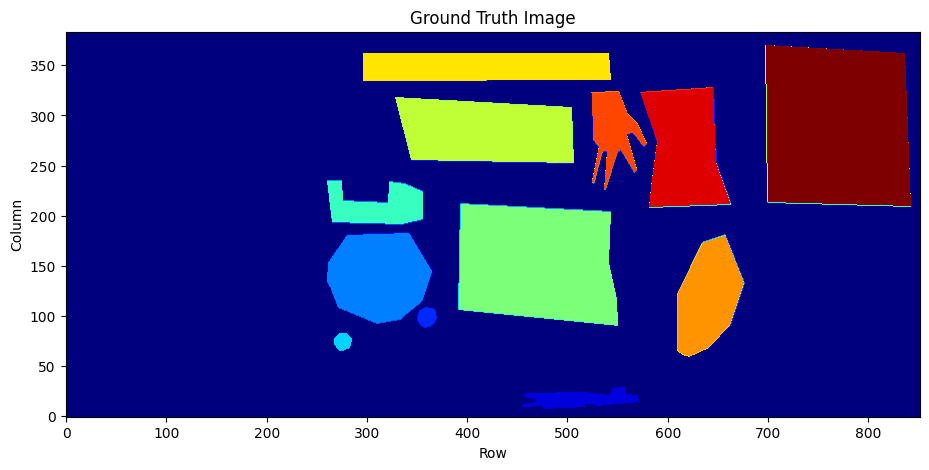

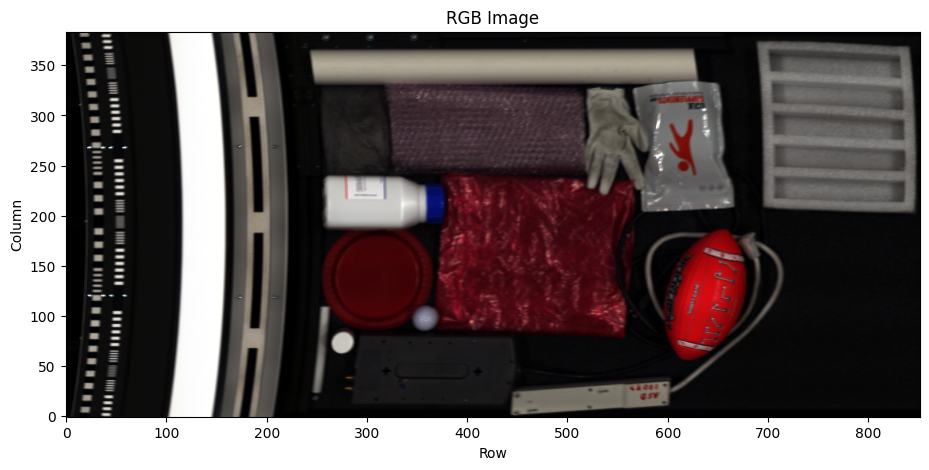

In [6]:
plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

sm2.display_RGB(im.Arr, wl, rotate=True)
plt.title('RGB Image');

# PART 2: Viewing a scatterplot of the hyperspectral image.

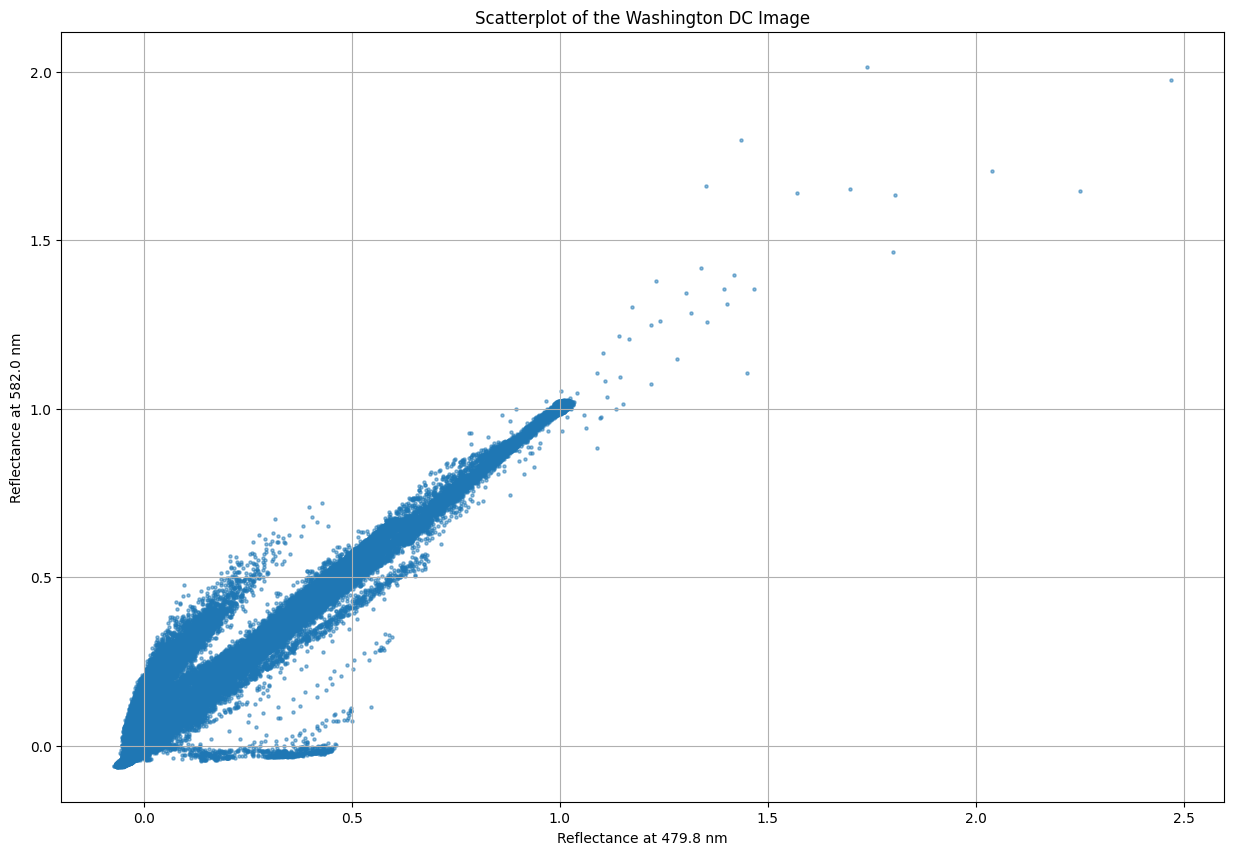

In [7]:
# Create a scatterplot of the data
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
plt.scatter(im.List[:,i1], im.List[:,i2], s=5, alpha=0.5);
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

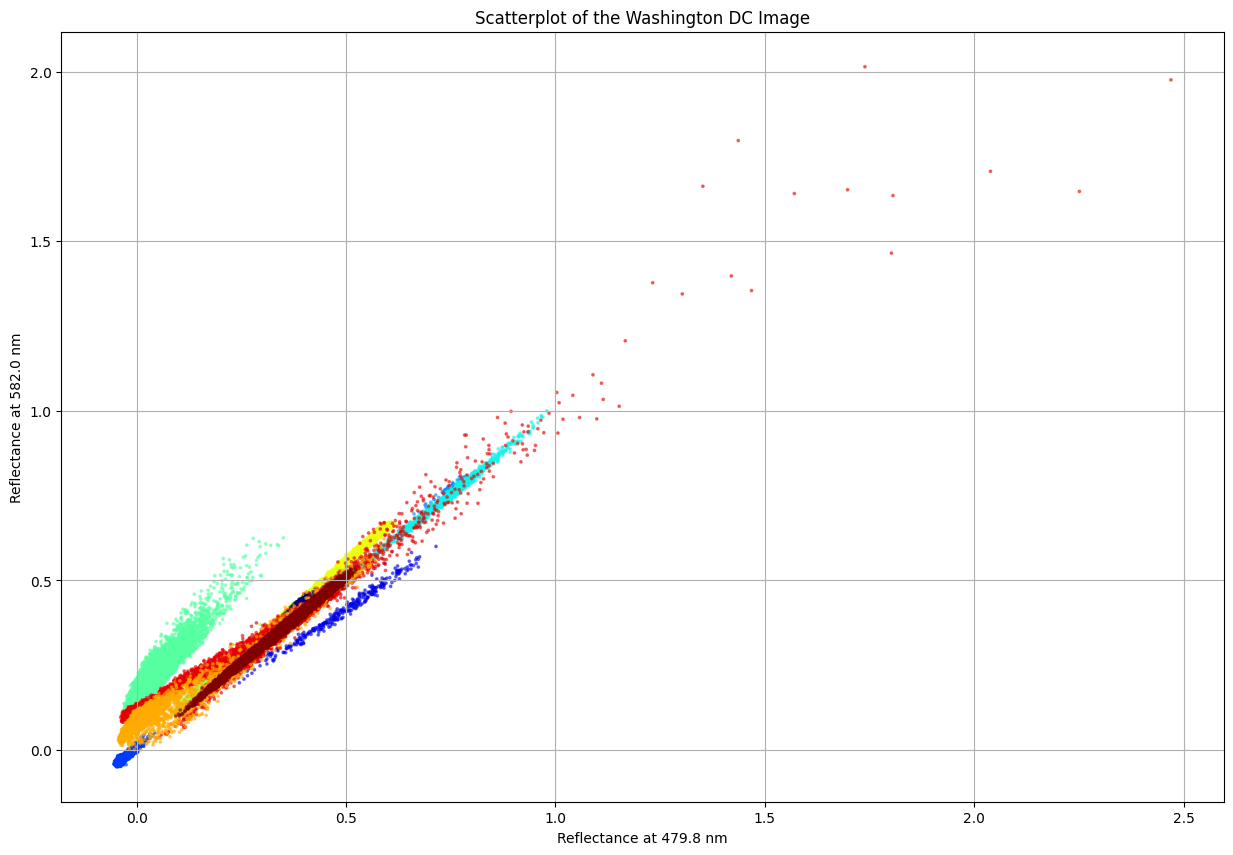

In [13]:
# Create a scatterplot of the data, colored by groundtruth class
i1 = 30
i2 = 60

plt.figure(figsize=(15,10))
gt_indiexes = np.where(gt_list>0)[0] # get hte indices only for pixels in ground truth classes
plt.scatter(im.List[gt_indiexes,i1], im.List[gt_indiexes,i2], c=gt_list[gt_indiexes], s=3, alpha=0.5, cmap='jet');
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Examining Individual Classes

In [8]:
groundtruth_classes.keys()

dict_keys(['surge_protector_hard', 'ping_pong_ball', 'red_lid', 'medicine_bottle_cap', 'plastic_bottle', 'red_bubble_wrap', 'clear_bubble_wrap', 'PVC_plumbing_pipe', 'polymer_football', 'glove', 'foil_bag', 'foam_packaging'])

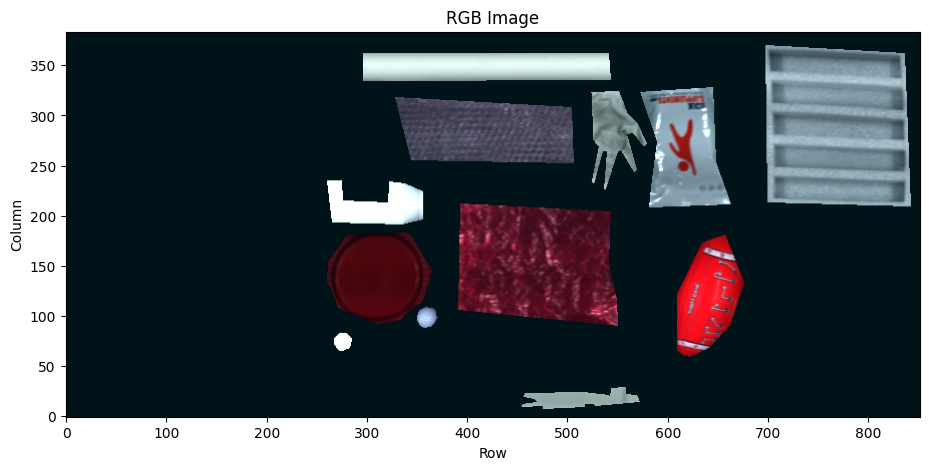

In [9]:
class_only_image = np.zeros((im.nrows, im.ncols, im.nbands))
for class_name in groundtruth_classes.keys():
    for x,y in groundtruth_classes[class_name]['locations']:
        class_only_image[int(x), int(y), :] = im.Arr[int(x), int(y), :]

sm2.display_RGB(class_only_image, wl, stretch_pct=[0,99], rotate=True)
plt.title('RGB Image');

## SLOW computation method:

In [8]:
nClasses = len(groundtruth_classes.keys())

In [16]:
want_to_waste_time = False
if want_to_waste_time:
    class_means = np.zeros((nClasses, im.nbands))
    C = np.zeros((im.nbands,im.nbands))

    # Compute means
    for class_idx, class_name in enumerate(groundtruth_classes.keys()):
        for x,y in groundtruth_classes[class_name]['locations']:
            # add to computation of class means
            spec = im.Arr[int(x), int(y), :].flatten()
            class_means[class_idx,:] = class_means[class_idx,:] + spec

    num_pixels_all_classes = 0
    for class_idx, class_name in enumerate(groundtruth_classes.keys()):
        num_pixels_in_class = len(groundtruth_classes[class_name]['locations'])
        num_pixels_all_classes = num_pixels_all_classes + num_pixels_in_class
        class_means[class_idx,:] = class_means[class_idx,:]/num_pixels_in_class


    # Compute class covariance (assuming all classes have the same covariance - LDA)
    for class_idx, class_name in enumerate(groundtruth_classes.keys()):
        for x,y in groundtruth_classes[class_name]['locations']:
            # add to computation of covariance
            spec = im.Arr[int(x), int(y), :].flatten()
            x_minus_mean = np.reshape((spec-class_means[class_idx,:]), (im.nbands,1))
            C = C + np.matmul(x_minus_mean, x_minus_mean.T)
            
    C = C / num_pixels_all_classes
         

Individual class covariance:

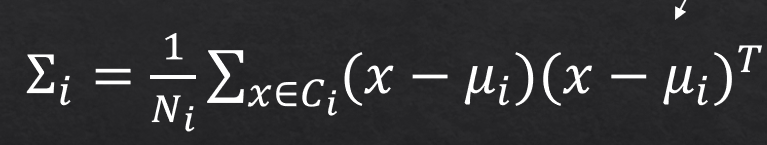

The LDA single covariance is computed using either of the following:

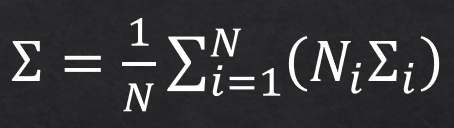

or

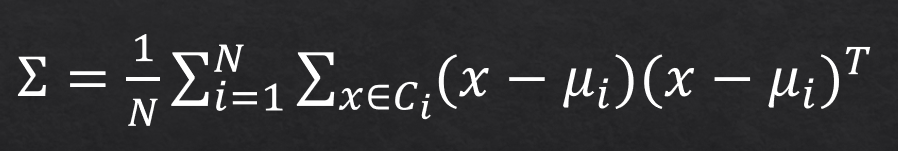

##  MUCH FASTER Computation using numpy:

In [9]:
class_means = np.zeros((nClasses, im.nbands))
class_covariances = np.zeros((nClasses, im.nbands, im.nbands))
C = np.zeros((im.nbands,im.nbands))

class_indices = np.unique(gt_list).astype(int)
for idx in class_indices:
    # skip idx==0 because that corresponds to the unlabeled (background) class
    if idx > 0: 
        class_locations = np.where(gt_list==idx)[0]
        num_class_spectra = len(class_locations) # N_i
        class_spectra = im.List[class_locations,:]
        class_means[idx-1,:] = np.mean(class_spectra, axis=0) # \mu_i
        class_covariances[idx-1,:,:] = np.cov(class_spectra.T) # \Sigma_i
        C = C + num_class_spectra*class_covariances[idx-1,:,:]

num_labeled_spectra = np.sum(gt_list>0)
C = C/num_labeled_spectra  # \Sigma

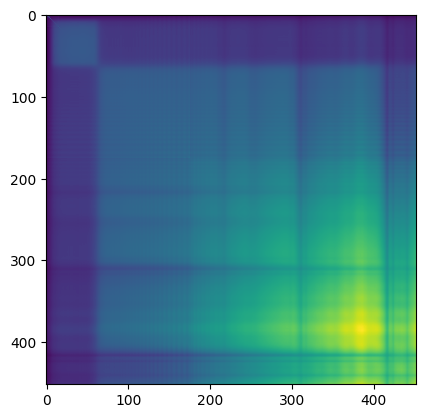

In [13]:
plt.imshow(C)

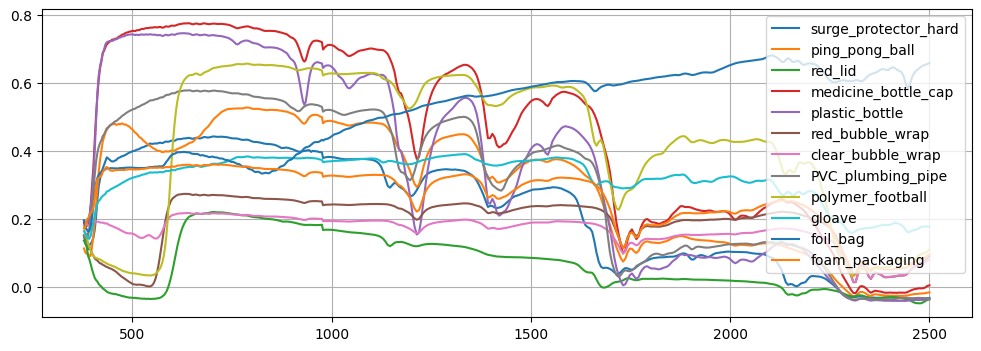

In [19]:
class_names = list(groundtruth_classes.keys())
plt.figure(figsize=(12,4))
for i in range(nClasses):
    plt.plot(wl, class_means[i,:], label=class_names[i])
plt.grid(True)
plt.legend()

In [20]:
Cinv = np.linalg.inv(C)

In [21]:
# Compute Mahalanobis Distance to mean for each class, for all pixels
imList_demean = np.zeros((im.nrows*im.ncols,im.nbands))
MD_all = np.zeros((im.nrows*im.ncols, nClasses))

for class_idx in range(nClasses):
    # demean each pixel
    mu = class_means[class_idx,:].flatten()
    for i in range(im.nbands):
        imList_demean[:,i] = im.List[:,i] - mu[i]

    MDs_part_1 = np.matmul(imList_demean, Cinv) 
    MDs = np.sum(MDs_part_1 * imList_demean, axis=1)
    MD = np.sqrt(MDs)
    MD_all[:,class_idx] = MD

In [10]:
# Faster method - using broadcasting to subtract mean

# Compute Mahalanobis Distance to mean for each class, for all pixels
imList_demean = np.zeros((im.nrows*im.ncols,im.nbands))
MD_all = np.zeros((im.nrows*im.ncols, nClasses))

for class_idx in range(nClasses):
    # demean each pixel
    mu = class_means[class_idx,:].flatten()
    imList_demean = im.List-mu

    MDs_part_1 = np.matmul(imList_demean, Cinv) 
    MDs = np.sum(MDs_part_1 * imList_demean, axis=1)
    MD = np.sqrt(MDs)
    MD_all[:,class_idx] = MD

NameError: name 'Cinv' is not defined

In [23]:
evals[evals<10**(-5)] = 10**(-5)

NameError: name 'evals' is not defined

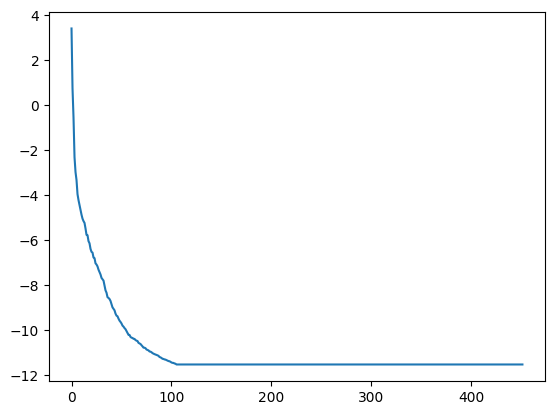

In [118]:
plt.plot(np.log(evals))

In [15]:
# Fastest method - using whitening and broadcasting to subtract mean

# Whitening the data (aka PCA)

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, im.List.T).T

print("imList shape: ", im.List.shape)
print("DiagMatrix shape: ", DiagMatrix.shape)
print("W shape: ", W.shape)

print(WimList.shape)

# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((im.nrows*im.ncols, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    print("mu shape: ", mu.shape)
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    print("Wmu shape: ", Wmu.shape)
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    print("WimList_demean shape: ", WimList_demean.shape)
    # compute Mahalanobis Distance
    #MDs = np.sum(WimList_demean**2, axis=1)
    #MDs = np.diag(np.matmul( (WimList - Wmu), (WimList - Wmu).T ))
    MDs = np.einsum('ij,ij->i', WimList_demean, WimList_demean)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

print(MD_all.shape)

imList shape:  (327168, 452)
DiagMatrix shape:  (452, 452)
W shape:  (452, 452)
(327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
mu shape:  (452,)
Wmu shape:  (452,)
WimList_demean shape:  (327168, 452)
(327168, 12)


In [88]:
LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (im.nrows,im.ncols))

# Viewing Results

Text(0.5, 1.0, 'LDA Class Predictio n Image')

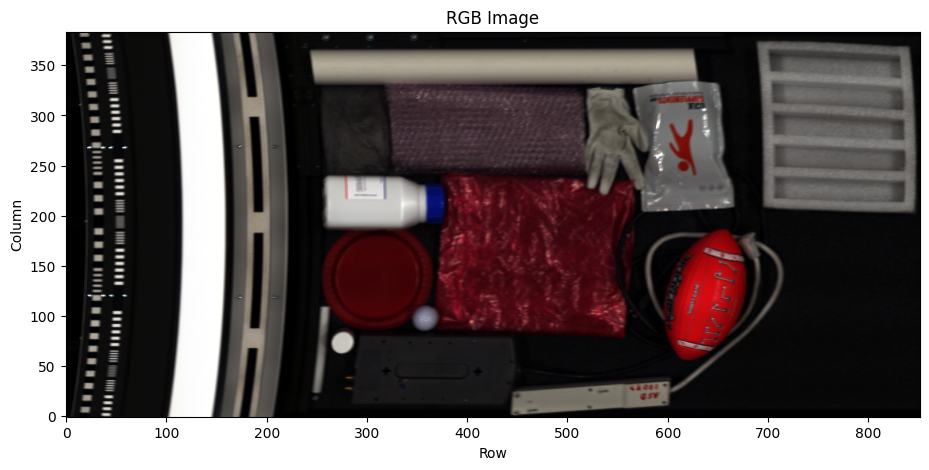

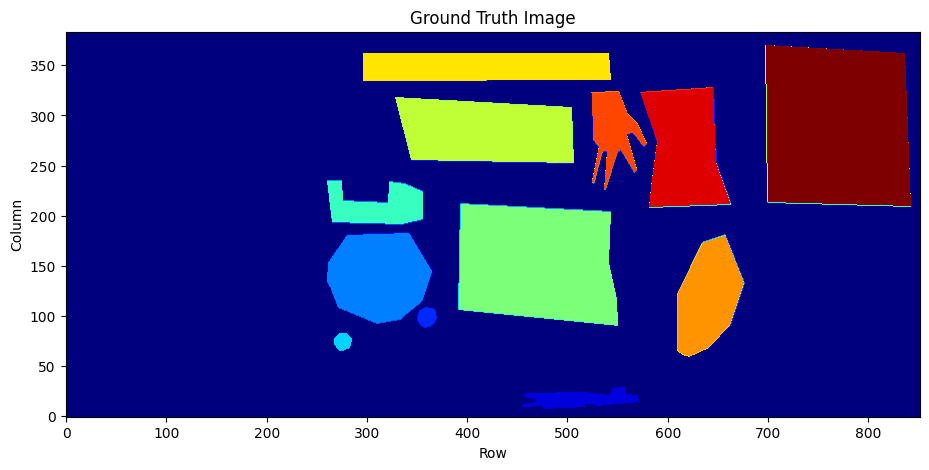

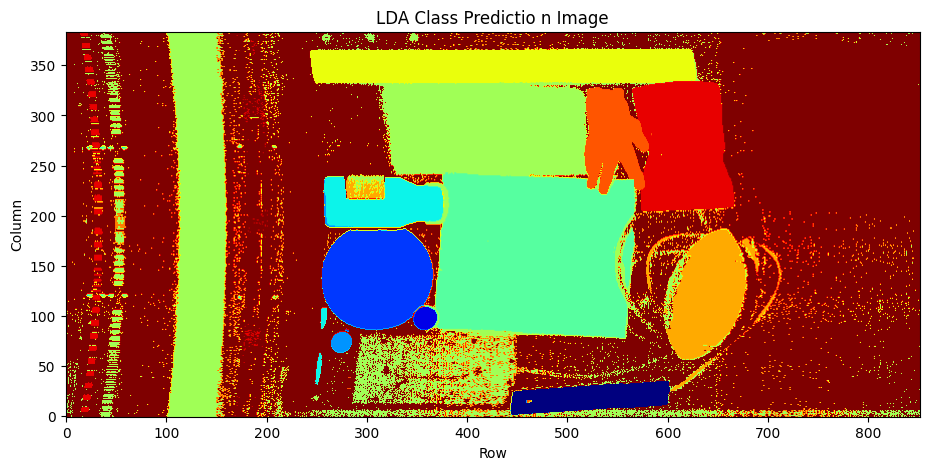

In [89]:
sm2.display_RGB(im.Arr, wl, rotate=True)
plt.title('RGB Image');

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(LDA_class_image), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('LDA Class Predictio n Image')

Text(0.5, 1.0, 'LDA Class Predictio n Image')

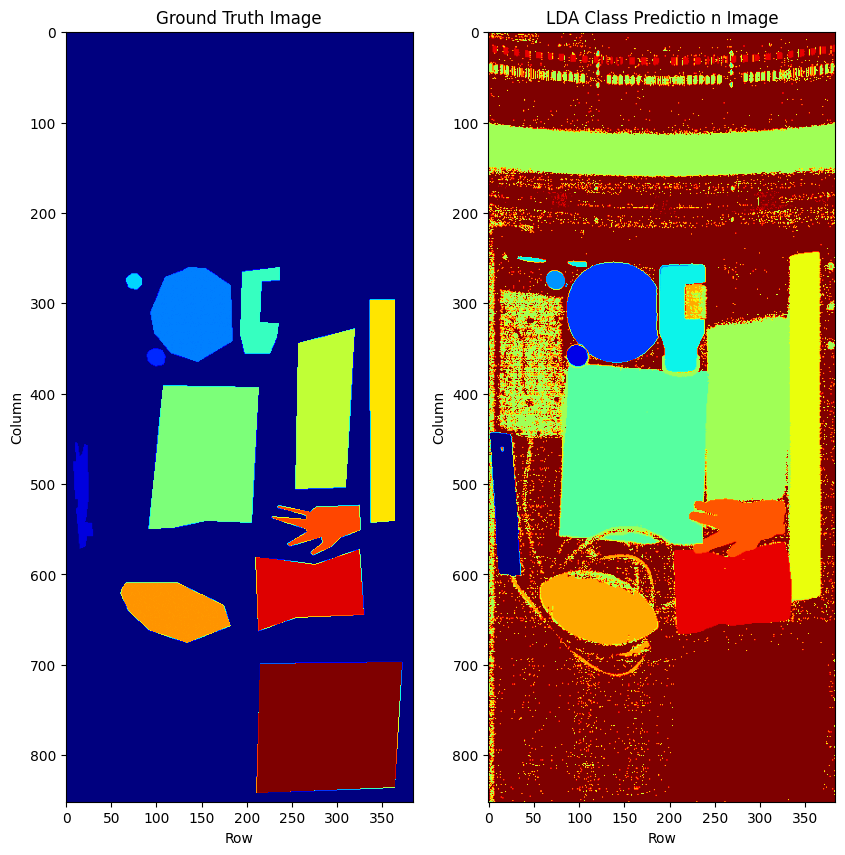

In [90]:
plt.figure(figsize=(10,10)) 

plt.subplot(1,2,1)
plt.imshow(gt_im, cmap='jet');
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

plt.subplot(1,2,2)
plt.imshow(LDA_class_image, cmap='jet');
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('LDA Class Predictio n Image')

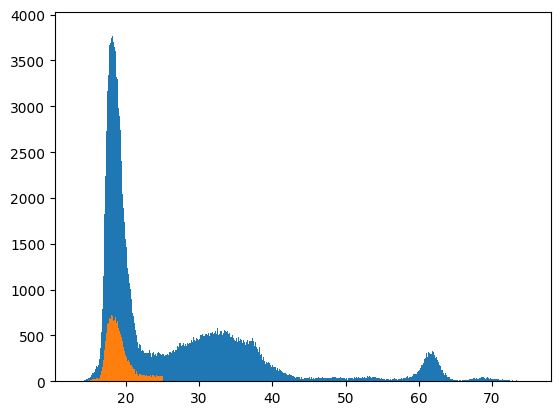

In [112]:
plt.hist(MD[MD<75], bins=1000);
plt.hist(MD[MD<25], bins=1000);

In [109]:
import importlib
from hsiViewer import hsi_layers_viewer as hlv
importlib.reload(hlv)
layers = {
    'Ground Truth': gt_im,
    'LDA Classification': LDA_class_image
}
hlv.viewer(im, layers)

x,y = [630,121]
x,y = [629,126]
x,y = [629,137]
x,y = [629,136]
x,y = [629,136]
x,y = [629,136]
x,y = [645,147]
x,y = [645,147]
x,y = [645,147]
x,y = [645,147]
x,y = [646,147]
x,y = [645,146]
x,y = [645,147]
x,y = [638,149]
x,y = [638,149]
x,y = [638,148]
x,y = [638,149]
x,y = [638,150]
x,y = [639,147]
x,y = [602,135]
x,y = [650,138]
x,y = [608,137]
x,y = [653,133]


# Whitening?

In [93]:
C = np.cov(im.List.T)

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-8)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, (im.List-mu).T).T

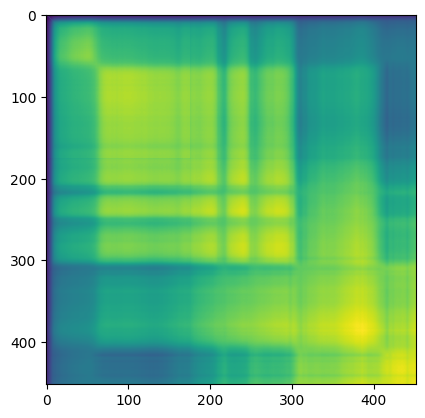

In [99]:
plt.imshow( np.cov(im.List.T) )

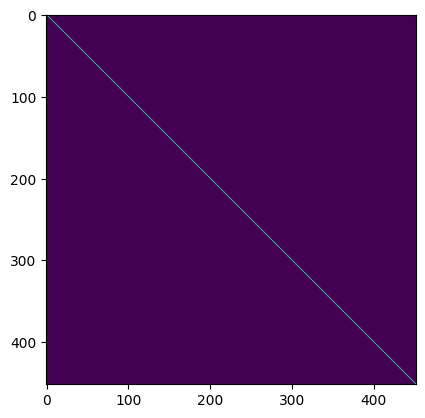

In [100]:
plt.imshow( np.cov(WimList.T) )

In [101]:
np.cov(WimList.T)

array([[ 1.00000000e+00, -9.05208081e-17, -4.87048859e-16, ...,
         2.28359153e-14, -1.57276049e-13, -2.44191173e-14],
       [-9.05208081e-17,  1.00000000e+00, -6.11580124e-17, ...,
        -8.98603407e-14,  1.66852132e-14,  2.37986111e-14],
       [-4.87048859e-16, -6.11580124e-17,  1.00000000e+00, ...,
        -7.04645201e-15,  9.58914090e-15, -1.34599873e-13],
       ...,
       [ 2.28359153e-14, -8.98603407e-14, -7.04645201e-15, ...,
         1.00000000e+00,  3.33067501e-09,  1.31656714e-09],
       [-1.57276049e-13,  1.66852132e-14,  9.58914090e-15, ...,
         3.33067501e-09,  1.00000000e+00, -5.16382046e-08],
       [-2.44191173e-14,  2.37986111e-14, -1.34599873e-13, ...,
         1.31656714e-09, -5.16382046e-08,  1.00000000e+00]])

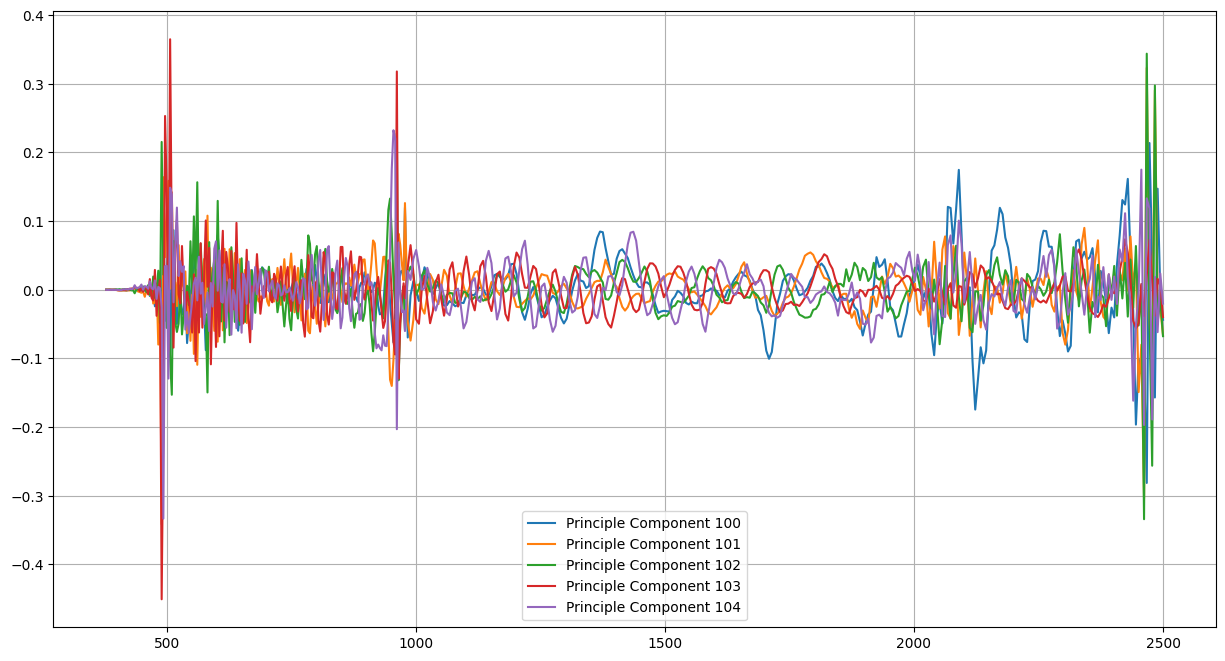

In [102]:
plt.figure(figsize=(15,8)) 
for i in range(100,105):
    plt.plot(wl, evecs[:,i], label=f'Principle Component {i}')
plt.grid(True)
plt.legend()

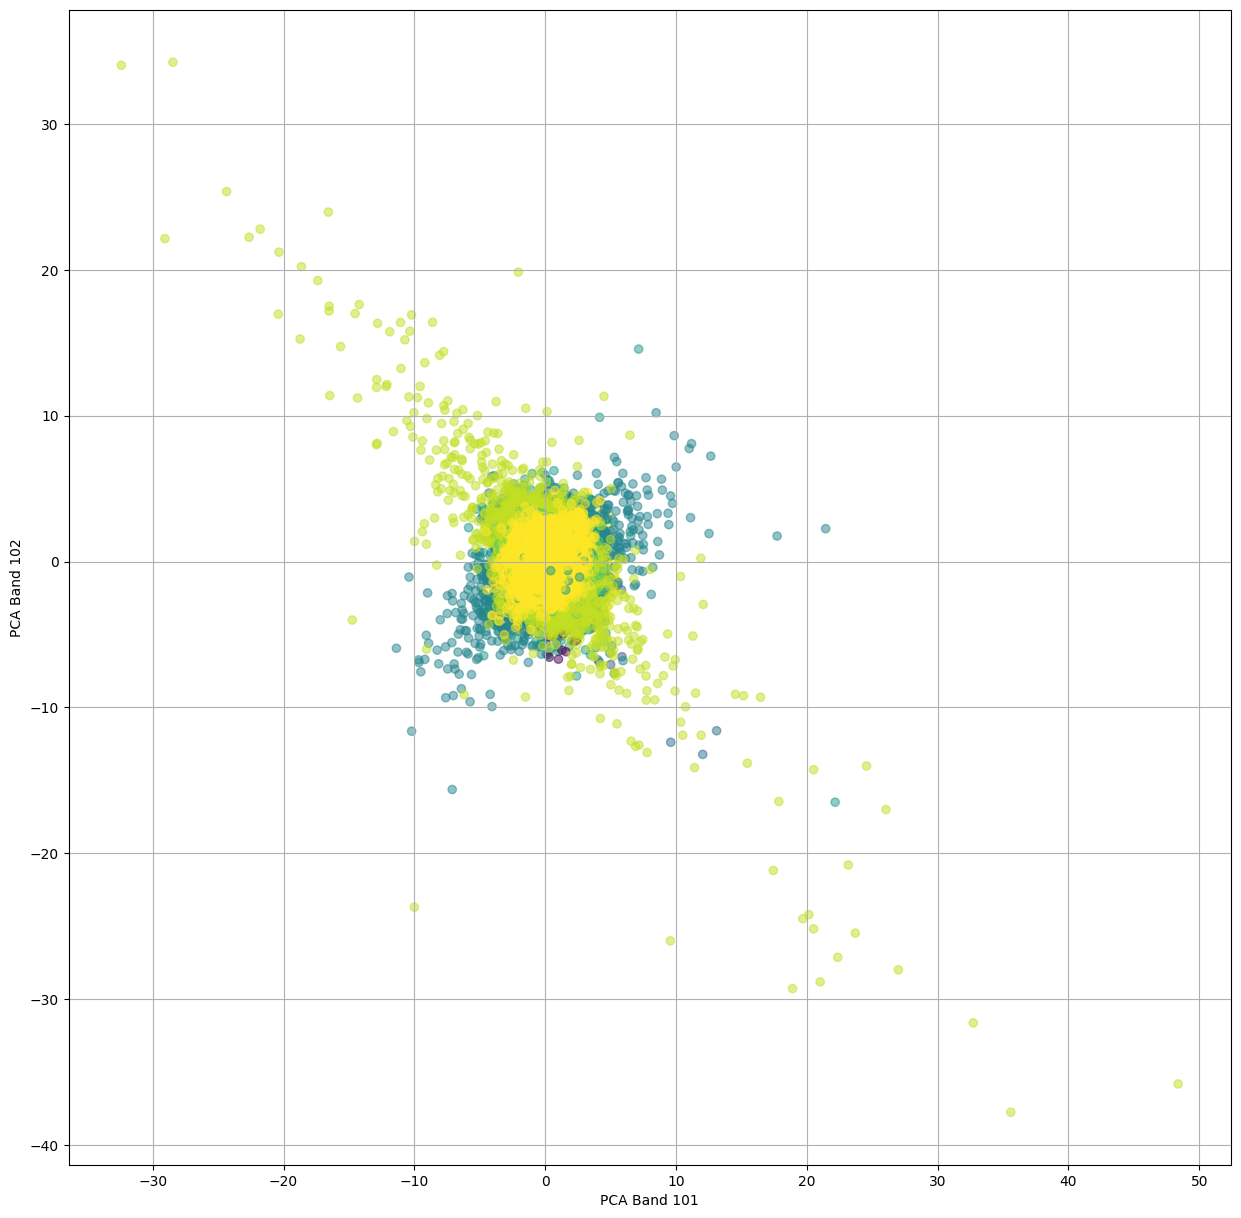

In [104]:
PCA_b1 = 101
PCA_b2 = 102

plt.figure(figsize=(15,15)) 
plt.scatter(WimList[:,PCA_b1], WimList[:,PCA_b2], c=LDA_class_list, alpha=0.5)
plt.grid(True);
plt.xlabel(f'PCA Band {PCA_b1}')
plt.ylabel(f'PCA Band {PCA_b2}');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-40.86700244525703..48.388524476045795].


Text(0.5, 1.0, 'Ground Truth Image')

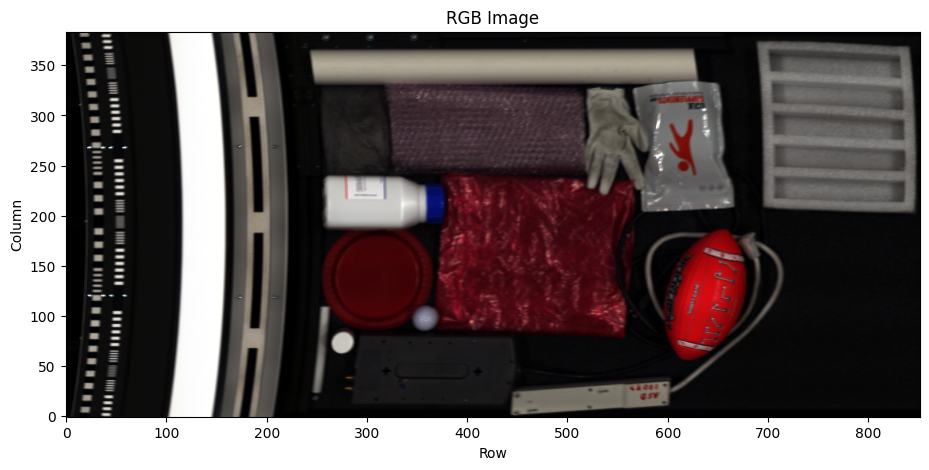

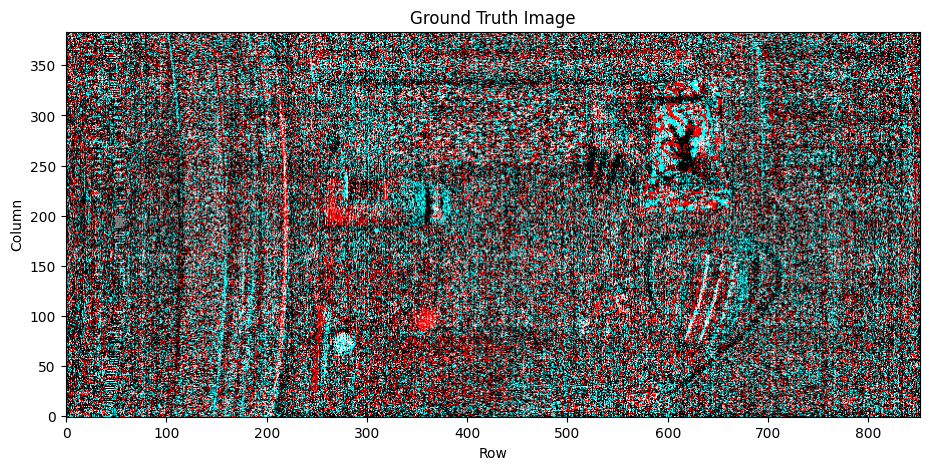

In [107]:
PCA_b1 = 101
PCA_b2 = 102
PCA_b2 = 103

PCA_image = np.reshape(WimList[:,[PCA_b1,PCA_b2,PCA_b2]], (im.nrows,im.ncols,3))

sm2.display_RGB(im.Arr, wl, rotate=True)
plt.title('RGB Image');

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(PCA_image), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')